In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Function:
    def __init__(self):
        self.epsilon = 1e-7

    def differentiate(self, data):
        return tf.cast((self.calcurate(data+self.epsilon) - self.calcurate(data-self.epsilon)) / (2*self.epsilon), dtype=tf.float32)

In [3]:
class Activation(Function):
    def __init__(self, name):
        super().__init__()

        self.name = name
        self.function_map = {'sigmoid' : self.sigmoid, 'relu' : self.relu, 'linear' : self.linear}
        self.weight = np.zeros((1,1))

    def sigmoid(self, data):
        return tf.math.divide(1, (1 + tf.math.pow(np.e, -data)))

    def relu(self, data):
        return tf.math.maximum(0, data)

    def linear(self, data):
        return data

    def calcurate(self, data): # activation
        return self.function_map[self.name](data)

In [4]:
class Loss(Function):
    def __init__(self, name):
        super().__init__()

        self.name = name
        self.function_map = {'mse' : self.meansquarederror, 'ce' : self.crossentropy}
        self.actual = 0

    def meansquarederror(self, predicted):
        return tf.math.reduce_mean(tf.math.pow(self.actual - predicted, 2))

    def crossentropy(self, predicted):
        return -tf.math.reduce_sum(self.actual*tf.math.log(predicted))

    def calcurate(self, data):
        return self.function_map[self.name](data)

In [5]:
class Optimizer:
    def __init__(self, learning_rate=1e-4):
        self.learning_rate = learning_rate

    def optimize(self, value):
        return self.learning_rate * value

In [6]:
class Dense:
    def __init__(self, input_shape, output_shape, initializer="lecun", activation="linear"):
        self.name = "dense"
        self.is_output_layer = False

        self.activation = Activation(activation.lower())

        initializer_map = {"xavier" : 2/(input_shape + output_shape), "he" : 2/input_shape}
        weight_stddev = initializer_map.get(initializer.lower(), 1/input_shape)

        self.weight = tf.Variable(tf.random.normal(shape=(input_shape, output_shape), mean=0, stddev=weight_stddev, dtype=tf.float32))
        self.bias = tf.Variable(tf.random.normal(shape=(1, output_shape), mean=0, stddev=0.01, dtype=tf.float32))
        self.optimizer = Optimizer()
    
    def calcurate(self, data): # propagation
        layer_output = tf.math.add(tf.matmul(data, self.weight), self.bias)
        activation_output = self.activation.calcurate(layer_output)
        return layer_output, activation_output

    def backpropagate(self, gradient, inputs, outputs):
        layer_gradient = tf.math.multiply(outputs, gradient)
        weight_gradient = tf.matmul(tf.transpose(inputs), layer_gradient)
        bias_gradient = tf.math.reduce_sum(layer_gradient, axis=0, keepdims=True)

        self.weight.assign_sub(self.optimizer.optimize(weight_gradient))
        self.bias.assign_sub(self.optimizer.optimize(bias_gradient))

        return tf.matmul(layer_gradient, tf.transpose(self.weight))

In [7]:
class Neural_network:
    def __init__(self):
        self.network = []

    def compile(self, loss_name, optimizer_config):
        self.loss_function = Loss(loss_name)
        self.optimizer = Optimizer(optimizer_config)

        for layer in self.network:
            layer.optimizer = self.optimizer
        self.network[-1].is_output_layer = True

        self.network_depth = len(self.network)

    def predict(self, data):
        self.calcuration_graph = [data]

        for layer in self.network:
            hidden_data, data = layer.calcurate(data)
            self.calcuration_graph.append(hidden_data)

        return data

    def evaluate(self, x, y):
        self.loss_function.actual = y
        loss = self.loss_function.calcurate(self.predict(x))
        return loss

    def fit(self, x, y, batch_size, epochs, verbose):
        loss_graph = []

        data_num = x.shape[0]
        mini_batch_num = data_num//batch_size
        epoch_digits = len(str(epochs))

        for epoch in range(epochs):
            for batch in range(mini_batch_num):
                index = np.random.randint(data_num, size=batch_size)
                batch_x = x[index, :]
                batch_y = y[index, :]

                prediction = self.predict(batch_x)
                self.loss_function.actual = batch_y

                gradient = self.loss_function.differentiate(prediction)
                for i in range(self.network_depth):
                    gradient = self.network[-i-1].backpropagate(gradient, self.calcuration_graph[-i-2], self.calcuration_graph[-i-1])

                loss = self.loss_function.calcurate(prediction)

                if verbose == 2:
                    print(f"epoch: {epoch:0{epoch_digits}d}, batch: {batch}/{mini_batch_num} |, loss: ", f'{loss:.4f}' if loss <= 0.0001 else f'{loss:.4e}')

            if verbose == 1:
                print(f"epoch: {epoch:0{epoch_digits}d} |, loss: ", f'{loss:.4f}' if loss > 0.0001 else f'{loss:.4e}')

            loss_graph.append(loss)

        self.loss_function.actual = 0
        return np.array(loss_graph)

In [8]:
x = np.array([[i] for i in range(100) for j in range(100)], dtype=np.float32) / 100
y = x + 0.1

In [9]:
model = Neural_network()
model.network.append(Dense(input_shape=1, output_shape=64, activation='relu'))
model.network.append(Dense(input_shape=64, output_shape=32, activation='relu'))
model.network.append(Dense(input_shape=32, output_shape=1, activation='linear'))

model.compile('mse', 1e-4)

2024-01-21 10:55:12.257218: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-21 10:55:12.258586: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [10]:
model.evaluate(x, y)

<tf.Tensor: shape=(), dtype=float32, numpy=0.41608456>

In [11]:
hist = model.fit(x, y, batch_size=64, epochs=100, verbose=1)

epoch: 000 |, loss:  0.4658
epoch: 001 |, loss:  0.2640
epoch: 002 |, loss:  0.1277
epoch: 003 |, loss:  0.0879
epoch: 004 |, loss:  0.0665
epoch: 005 |, loss:  0.0612
epoch: 006 |, loss:  0.0680
epoch: 007 |, loss:  0.0722
epoch: 008 |, loss:  0.0732
epoch: 009 |, loss:  0.0879
epoch: 010 |, loss:  0.0837
epoch: 011 |, loss:  0.0831
epoch: 012 |, loss:  0.0962
epoch: 013 |, loss:  0.0748
epoch: 014 |, loss:  0.0851
epoch: 015 |, loss:  0.0910
epoch: 016 |, loss:  0.0672
epoch: 017 |, loss:  0.0626
epoch: 018 |, loss:  0.0667
epoch: 019 |, loss:  0.0669
epoch: 020 |, loss:  0.0773
epoch: 021 |, loss:  0.0731
epoch: 022 |, loss:  0.0723
epoch: 023 |, loss:  0.0730
epoch: 024 |, loss:  0.0735
epoch: 025 |, loss:  0.0771
epoch: 026 |, loss:  0.1032
epoch: 027 |, loss:  0.0670
epoch: 028 |, loss:  0.0632
epoch: 029 |, loss:  0.0767
epoch: 030 |, loss:  0.0813
epoch: 031 |, loss:  0.0777
epoch: 032 |, loss:  0.0578
epoch: 033 |, loss:  0.0745
epoch: 034 |, loss:  0.0763
epoch: 035 |, loss: 

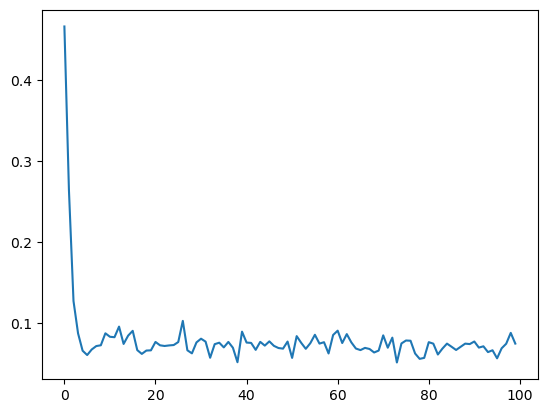

In [12]:
plt.plot(hist)
plt.show()

In [13]:
model.evaluate(x, y)

<tf.Tensor: shape=(), dtype=float32, numpy=0.06933919>

make tensorflow model to compare

In [14]:
tf_model = tf.keras.Sequential()
tf_model.add(tf.keras.layers.Dense(64, activation='relu'))
tf_model.add(tf.keras.layers.Dense(32, activation='relu'))
tf_model.add(tf.keras.layers.Dense(1, activation='linear'))

tf_model.compile(loss='mse', optimizer='sgd')

In [15]:
tf_model.evaluate(x, y)

313/313 [==============================] - 1s 2ms/step - loss: 0.3684


0.3684169352054596

In [16]:
tf_hist = tf_model.fit(x, y, epochs=100, batch_size=64, verbose=1)

Epoch 1/100


157/157 [==============================] - 1s 3ms/step - loss: 0.0554
Epoch 2/100
157/157 [==============================] - 0s 2ms/step - loss: 0.0141
Epoch 3/100
157/157 [==============================] - 0s 2ms/step - loss: 0.0055
Epoch 4/100
157/157 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 5/100
157/157 [==============================] - 0s 2ms/step - loss: 5.9862e-04
Epoch 6/100
157/157 [==============================] - 0s 2ms/step - loss: 1.7811e-04
Epoch 7/100
157/157 [==============================] - 1s 4ms/step - loss: 5.3882e-05
Epoch 8/100
157/157 [==============================] - 0s 2ms/step - loss: 1.8451e-05
Epoch 9/100
157/157 [==============================] - 0s 2ms/step - loss: 8.3898e-06
Epoch 10/100
157/157 [==============================] - 1s 3ms/step - loss: 5.3966e-06
Epoch 11/100
157/157 [==============================] - 1s 4ms/step - loss: 4.3236e-06
Epoch 12/100
157/157 [==============================] - 0s 3ms/step - loss: 3.79

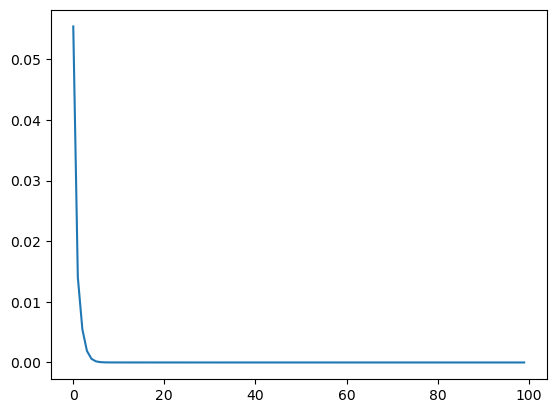

In [17]:
plt.plot(tf_hist.history['loss'])
plt.show()